# Imports


In [0]:
%tensorflow_version 1.x
import cv2
import json
import numpy as np
import pandas as pd
from pathlib import Path 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import resample
import skimage.io as io
from keras.applications import *
from keras.layers import *
from keras.models import *
from keras.activations import *
from keras.optimizers import *
from keras.callbacks import *
from keras.utils import *
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from google.colab.patches import cv2_imshow
from google.colab import drive
from IPython.core.display import display
import os
import shutil
import re
import zipfile
import matplotlib.pyplot as plt
from datetime import datetime
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from time import time

Using TensorFlow backend.


 # Helpers
 

In [0]:
def evaluate_model():
    results = model.evaluate(*val_data)
    accuracies = {}
    losses = {}
    for k, v in zip(model.metrics_names, results):
        if k.endswith('acc'):
            accuracies[k] = round(v * 100, 4) 
        else:
            losses[k] = v
    return accuracies

def get_random_eraser(p, frac, v_l=0, v_h=1, pixel_level=False):
    w, h = int(img_size[0] * frac), int(img_size[1] * frac)

    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

def find_lr(start_lr, end_lr):
    finder = LRFinder(start_lr, end_lr, len(train_gen))
    # backup model weights so they don't get disturbed
    weights = model.get_weights()     
    try:
        history = model.fit_generator(
            train_gen,
            validation_data=val_data,
            epochs=5, verbose=1, callbacks=[finder],
        )   
    finally:    
        # make sure model weights are restored 
        model.set_weights(weights)    
    return finder
    
class LRFinder(Callback):    
    def __init__(self, start_lr, end_lr, stepsize, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.stepsize = stepsize
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/stepsize)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)        
        
        K.set_value(self.model.optimizer.lr, lr)  

    def plot(self, lskip=10, rskip=10):
        lrs = self.lrs[lskip:-rskip]
        losses = self.smoothed_losses[lskip:-rskip]

        output_notebook()
        p = figure(title='Learning Rate Finder', x_axis_label='LR', y_axis_label='Loss')
        p.line(lrs, losses)
        
        p.add_tools(
            HoverTool(
                tooltips=[('LR', '$data_x'), ('Loss', '$data_y')]
            )
        )

        show(p)
        
        best_idxs = np.argpartition(losses, 15)[:15]
        best_lrs = np.take(lrs, best_idxs)
        print(f"Best LRs: {best_lrs}")    

class CyclicLR(Callback):
    def __init__(self, lr, stepsize, mm=None, mode='triangular2', gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.min_lr, self.max_lr = lr
        self.cycle_mm = mm is not None
        if self.cycle_mm:
            self.min_mm, self.max_mm = mm
        self.stepsize = stepsize
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None, new_stepsize=None):
        if new_base_lr != None:
            self.min_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_stepsize != None:
            self.stepsize = new_stepsize
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.stepsize))
        x = np.abs(self.clr_iterations/self.stepsize - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.min_lr + (self.max_lr-self.min_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.min_lr + (self.max_lr-self.min_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
    
    def cmm(self):    
        cycle = np.floor(1+self.clr_iterations/(2*self.stepsize))        
        x = np.abs(self.clr_iterations/self.stepsize - 2*cycle + 1) 
        return self.max_mm - (self.max_mm - self.min_mm)*np.maximum(0,(1-x))        
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            lr =  self.min_lr
            if self.cycle_mm:
                mm = self.min_mm
        else:
            lr = self.clr()
            if self.cycle_mm:
                mm = self.cmm()

        K.set_value(self.model.optimizer.lr, lr)        
        if self.cycle_mm: 
            K.set_value(self.model.optimizer.momentum, mm)        

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        if self.cycle_mm: 
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())        
        if self.cycle_mm: 
            K.set_value(self.model.optimizer.momentum, self.cmm())        

def plot_stats():
    hist = history.history
    lr_hist = cyc_lr.history

    # Plot LR and Momentum

    p = figure(title='Learning Rate', x_axis_label='Iterations', y_axis_label='LR')

    p.line(lr_hist['iterations'], lr_hist['lr'], legend='LR')
    if 'momentum' in lr_hist:
        p.line(lr_hist['iterations'], lr_hist['momentum'], color='green', legend='Momentum')
    p.add_tools(HoverTool())
    show(p)

    # Plot Loss

    p = figure(title='Overall Loss', x_axis_label='Epochs', y_axis_label='loss')

    y = hist['loss']
    x = range(len(y))
    p.line(x, y, color='red', legend='Training')

    y = hist['val_loss']
    x = range(len(y))
    p.line(x, y, color='blue', legend='Validation')

    p.add_tools(
        HoverTool(
            tooltips=[('Epochs', '$data_x'), ('Loss', '$data_y')]
        )
    )
    show(p)

    # Plot accuracies

    for k, y in hist.items():
        if not k.endswith('acc') or k.startswith('val'): 
            continue
        
        p = figure(title=k, x_axis_label='Epochs', y_axis_label='Accuracy')
        
        p.line(range(len(y)), y, color='red', legend='Training')
        p.line(range(len(y)), hist[f'val_{k}'], color='blue', legend='Validataion')
        p.add_tools(
            HoverTool(
                tooltips=[('Epochs', '$data_x'), ('Accuracy', '$data_y')]
            )
        )
        
        show(p)

def imread(path):
    return cv2.resize(cv2.imread(path), img_size) 


# Training

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg
...,...,...,...,...,...,...,...,...,...
13568,male,Average,35-45,slightly-overweight,None,Normal,Happy,Front-Frontish,resized/13570.jpg
13569,female,Average,25-35,normal-healthy,Daily/Office/Work Bag,Fancy,Neutral,Front-Frontish,resized/13571.jpg
13570,female,Bad,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Side,resized/13572.jpg
13571,female,Bad,25-35,over-weight,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/13573.jpg


gender  imagequality  age    weight               carryingbag            footwear  emotion        bodypose      
male    Good          55+    underweight          None                   Normal    Sad            Side                1
        Bad           15-25  underweight          None                   Normal    Happy          Front-Frontish      1
female  Good          15-25  slightly-overweight  Daily/Office/Work Bag  Normal    Happy          Side                1
                                                                                   Angry/Serious  Front-Frontish      1
male    Bad           15-25  underweight          None                   Normal    Neutral        Back                1
                                                                                                                   ... 
        Average       35-45  normal-healthy       None                   Normal    Neutral        Front-Frontish     80
female  Average       25-35  normal-healthy    

(11537,) (2036,)


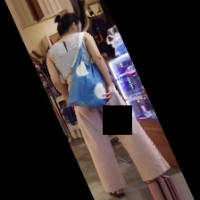

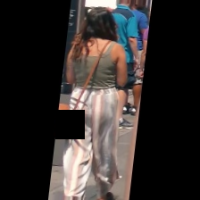

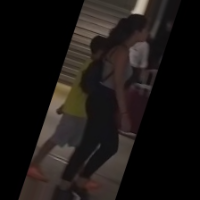

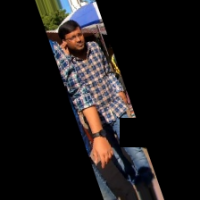

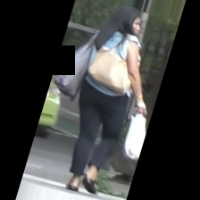

In [0]:
batch_size = 32
img_size = (224,) * 2

cur_dir = Path.cwd()
mount_dir = cur_dir / 'drive'

drive.mount(str(mount_dir))

# extract zipfile
my_drive_dir = mount_dir / 'My Drive' / 'assignment_5'
with zipfile.ZipFile(my_drive_dir / 'hvc_data.zip', 'r') as f:
    f.extractall(cur_dir)

df = pd.read_csv('hvc_annotations.csv')
del df["filename"] # remove unwanted column
display(df)

image_col = df.columns[-1]
label_cols = list(df.columns[:-1])
display(df[label_cols].groupby(label_cols).size().sort_values())

images = df[image_col].to_numpy()
# apply one-hot encoding separately on each column containing labels
one_hot_labels = {col: pd.get_dummies(df[[col]]).to_numpy() for col in label_cols}

# ensures a nice and even split of data
# can't do this for all columns, because the data is too sparse
stratify_cols = ['gender', 'imagequality', 'age', 'bodypose']
# get indicies for splitting data into train and validation sets
splits = next(StratifiedShuffleSplit(test_size=0.15).split(images, df[stratify_cols]))

# split data by indicies returned in split
(im_train, y_train), (im_val, y_val) = [
    (
        images[idxs], 
        {name: clsy[idxs] for name, clsy in one_hot_labels.items()}
    ) 
    for idxs in splits
]

# pre-load images from im_val into x_val
x_val = np.empty((len(im_val), *img_size, 3))
for i, path in enumerate(im_val):
    x_val[i] = imread(path)
val_data = x_val, y_val

print(im_train.shape, im_val.shape)

aug = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=25,
    preprocessing_function=get_random_eraser(p=1, frac=0.15),
)

class PersonDataGenerator(Sequence):
    def __len__(self):
        return len(im_train) // batch_size
    
    def __getitem__(self, idx):
        # create slice for current batch of train data
        batch_slice = slice(idx * batch_size, (idx + 1) * batch_size)        
        
        # read images from paths in current batch of training images
        x = np.empty((batch_size, *img_size, 3))
        for i, path in enumerate(im_train[batch_slice]):
            x[i] = imread(path)
        
        # apply image augmentation
        x = aug.flow(x, shuffle=False, batch_size=len(x)).next()
        
        # create train label batch
        y = {name: clsy[batch_slice] for name, clsy in y_train.items()}

        return x, y

train_gen = PersonDataGenerator()

for img in train_gen[0][0][:5]:
    cv2_imshow(cv2.resize(img, (200, 200)))












Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 3)  12          re_lu_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 224, 224, 16) 91          batch_normalization_1[0][0]      
_________________________________________________________________________________

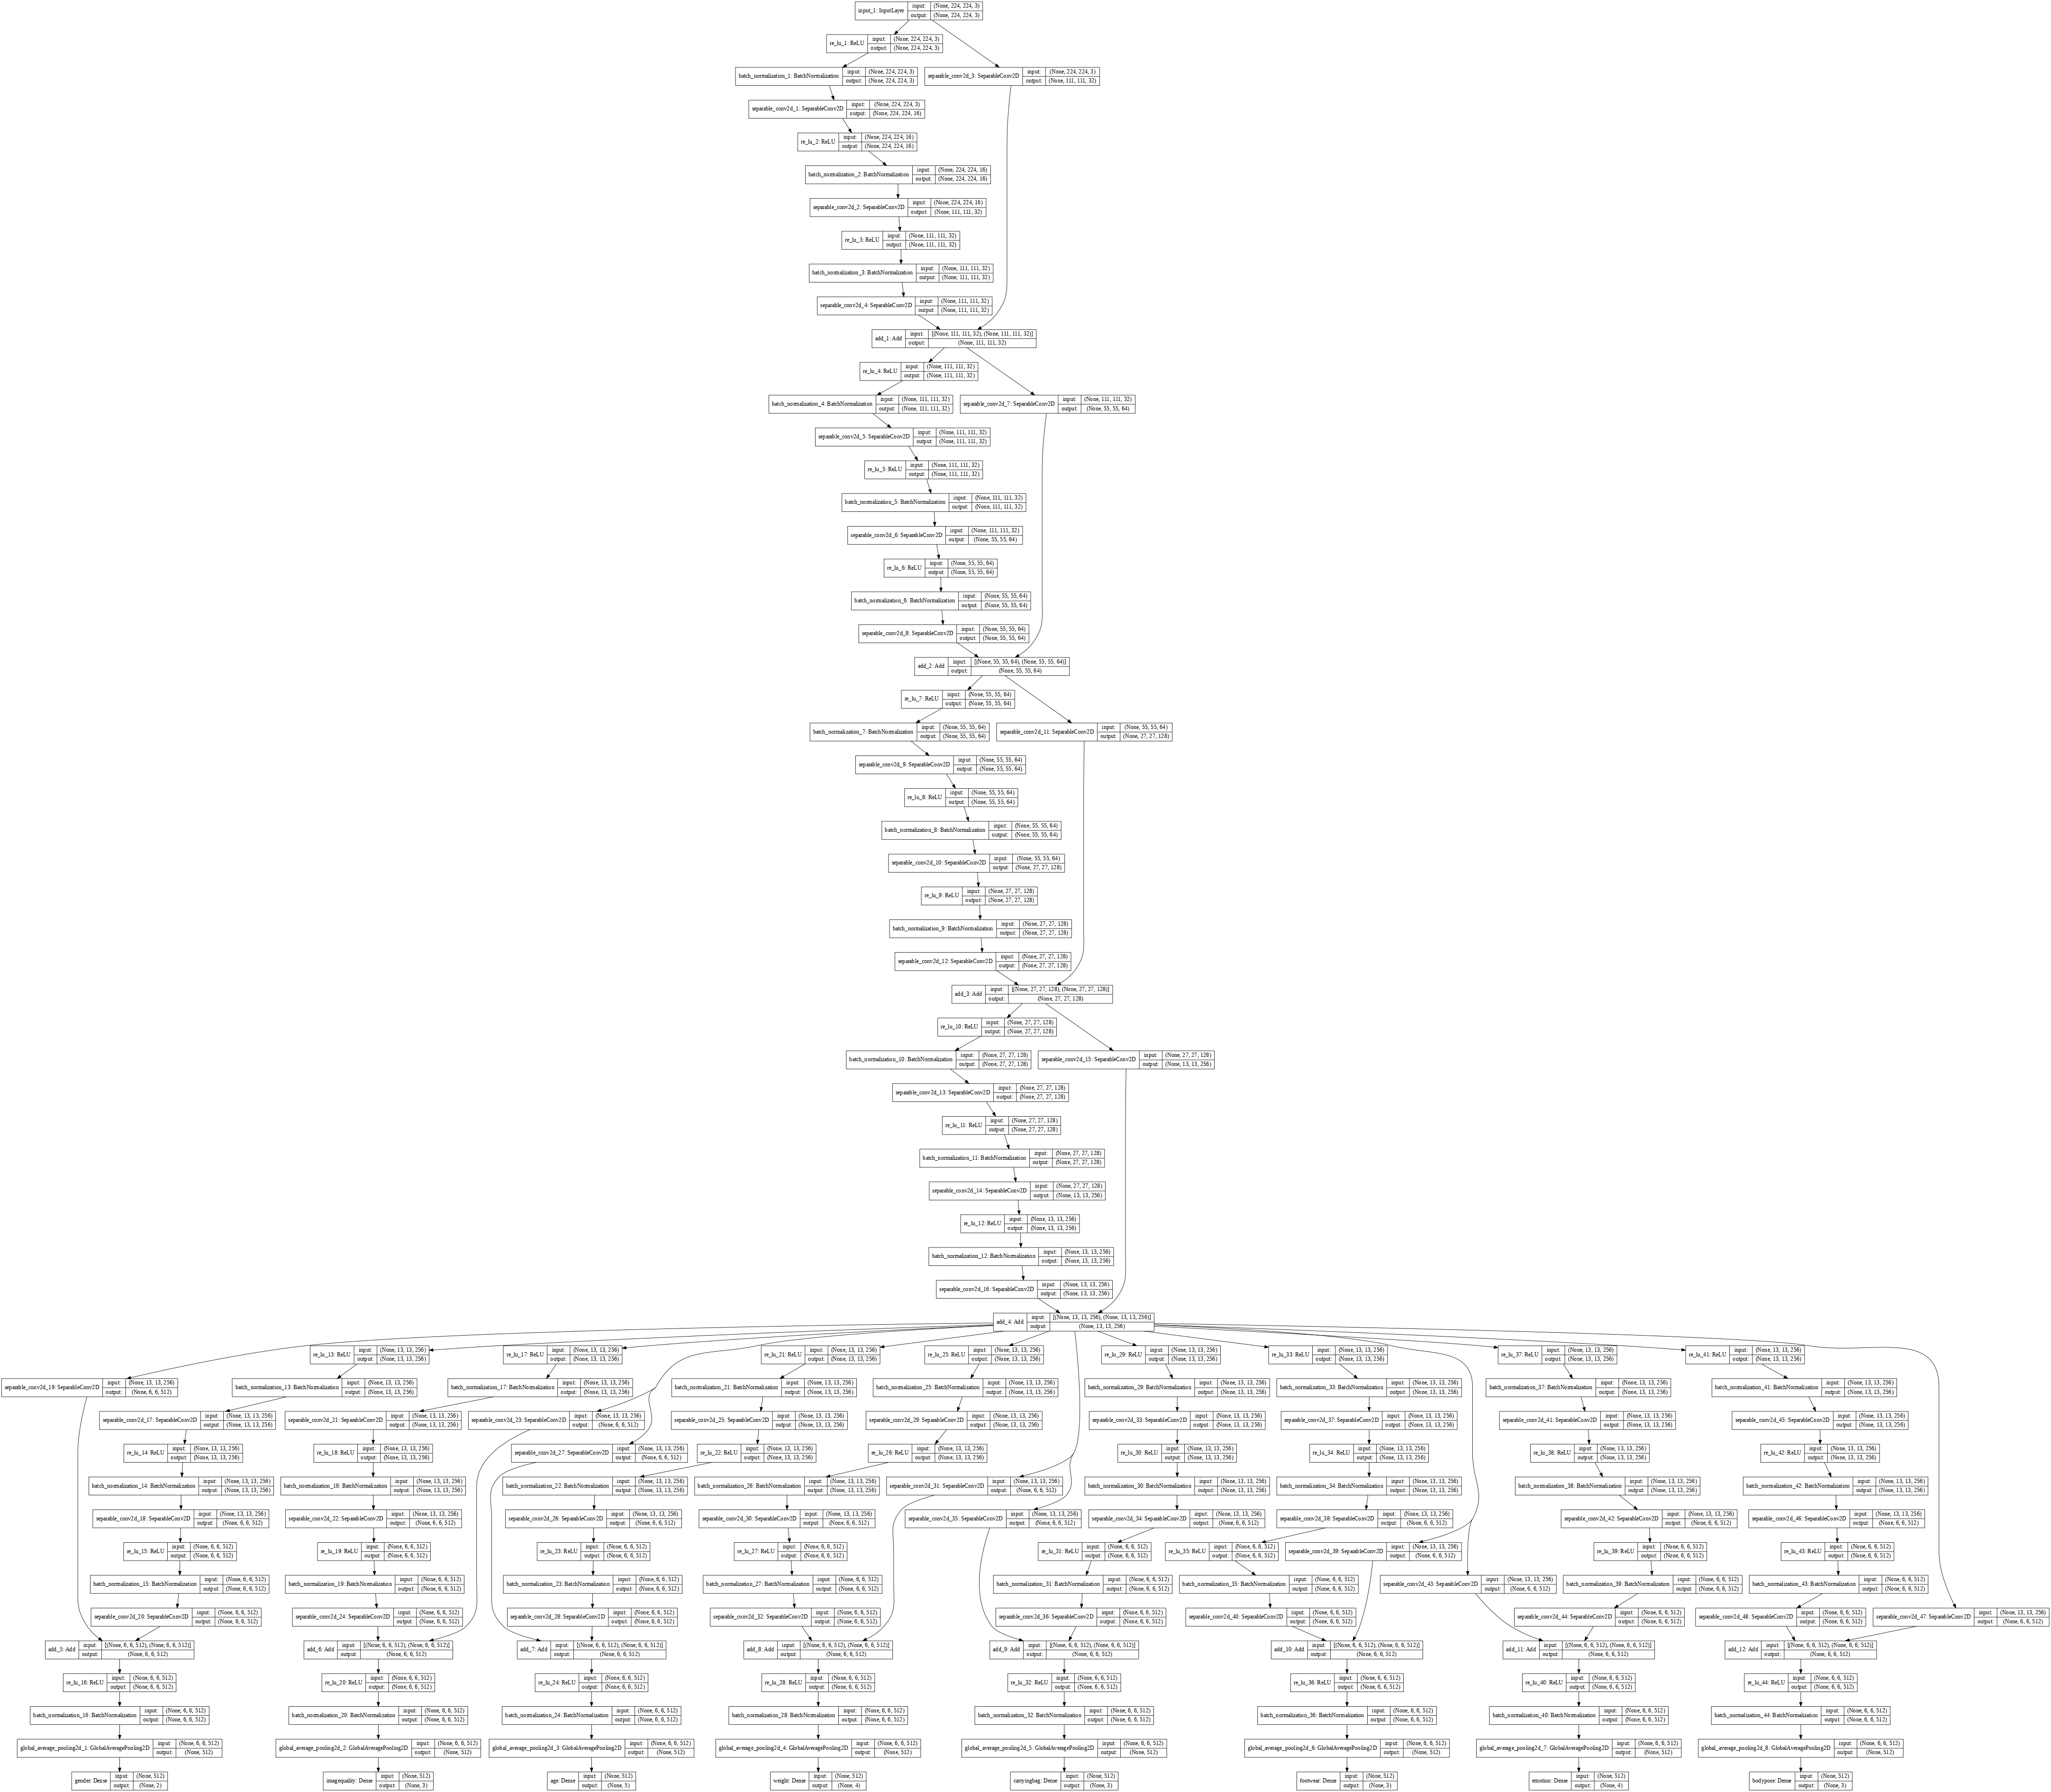

In [0]:
def build_model():
    inputs = x = Input(shape=(*img_size, 3))

    x = skip_conv(x, f=16)    
    for _ in range(3):
        x = skip_conv(x)    

    outputs = [
        # build one tower for every class of labels
        head(x, y_train[col].shape[-1], col) for col in label_cols
    ]

    return Model(inputs=inputs, outputs=outputs)

def head(x, n, name):
    x = skip_conv(x)
    x = relu_bn(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(n, name=name, activation='softmax')(x)
    return x

def skip_conv(x, f=None):
    if f is None:
        f = int(x.shape[-1])
    y = x
    
    x = relu_bn(x)
    
    x = SeparableConv2D(f, 3, padding='same')(x)
    x = relu_bn(x)
    
    f *= 2
    x = SeparableConv2D(f, 3, strides=2)(x)
    x = relu_bn(x)
    y = SeparableConv2D(f, 3, strides=2)(y)

    x = SeparableConv2D(f, 3, padding='same')(x)
    
    x = Add()([x, y])
    return x

def skip_no_conv(x):
    f = int(x.shape[-1])
    y = x
    
    for _ in range(3):
        x = relu_bn(x)
        x = SeparableConv2D(f, 3, padding='same')(x)

    x = Add()([x, y])
    return x

def relu_bn(x):
    x = ReLU()(x)
    x = BatchNormalization()(x)
    return x

model = build_model()
model.summary()
display(plot_model(model, show_shapes=True, to_file='model.png', dpi=60))

model.compile(
    optimizer=RMSprop(),
    loss='categorical_crossentropy', 
    metrics=['accuracy'],
)   

In [0]:
finder = find_lr(1e-5, 0.5)
finder.plot()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
327/360 [==========================>...] - ETA: 13s - loss: 13.8236 - gender_loss: 1.3845 - imagequality_loss: 1.6535 - age_loss: 2.0190 - weight_loss: 1.9222 - carryingbag_loss: 1.7108 - footwear_loss: 1.9034 - emotion_loss: 1.7588 - bodypose_loss: 1.4715 - gender_acc: 0.5416 - imagequality_acc: 0.4407 - age_acc: 0.2925 - weight_acc: 0.4726 - carryingbag_acc: 0.4621 - footwear_acc: 0.4346 - emotion_acc: 0.5281 - bodypose_acc: 0.4923

Best LRs: [0.01485268 0.0060287  0.00503394 0.01398619 0.01441292 0.00550891
 0.005677   0.00585021 0.0064022  0.00621265 0.00518753 0.0162541
 0.01577285 0.01530585 0.00659754]


In [0]:
early = EarlyStopping(patience=20, restore_best_weights=True, verbose=True)
cyc_lr = CyclicLR(lr=(2e-3, 2e-2), stepsize=len(train_gen) * 8)
 
history = model.fit_generator(
    train_gen,
    validation_data=val_data,
    epochs=100, verbose=2,
    callbacks=[cyc_lr, early],
)

display(evaluate_model())
plot_stats()

Epoch 1/100
 - 135s - loss: 8.0605 - gender_loss: 0.6975 - imagequality_loss: 0.9973 - age_loss: 1.4666 - weight_loss: 1.0258 - carryingbag_loss: 0.9419 - footwear_loss: 1.0075 - emotion_loss: 0.9593 - bodypose_loss: 0.9646 - gender_acc: 0.5680 - imagequality_acc: 0.5365 - age_acc: 0.3781 - weight_acc: 0.6242 - carryingbag_acc: 0.5501 - footwear_acc: 0.5212 - emotion_acc: 0.6980 - bodypose_acc: 0.6012 - val_loss: 7.9203 - val_gender_loss: 0.6854 - val_imagequality_loss: 0.9818 - val_age_loss: 1.4372 - val_weight_loss: 0.9706 - val_carryingbag_loss: 0.9292 - val_footwear_loss: 1.0545 - val_emotion_loss: 0.9081 - val_bodypose_loss: 0.9535 - val_gender_acc: 0.5624 - val_imagequality_acc: 0.5530 - val_age_acc: 0.3988 - val_weight_acc: 0.6415 - val_carryingbag_acc: 0.5555 - val_footwear_acc: 0.4548 - val_emotion_acc: 0.7107 - val_bodypose_acc: 0.6174
Epoch 2/100
 - 134s - loss: 7.8221 - gender_loss: 0.6823 - imagequality_loss: 0.9651 - age_loss: 1.4406 - weight_loss: 1.0013 - carryingbag_lo

{'age_acc': 41.945,
 'bodypose_acc': 81.1395,
 'carryingbag_acc': 65.4224,
 'emotion_acc': 71.0216,
 'footwear_acc': 67.2888,
 'gender_acc': 84.9214,
 'imagequality_acc': 57.2692,
 'weight_acc': 64.6857}

In [0]:
finder = find_lr(1e-5, 0.002)
finder.plot()

Epoch 1/5
360/360 [==============================] - 134s 372ms/step - loss: 6.1945 - gender_loss: 0.3205 - imagequality_loss: 0.8630 - age_loss: 1.3072 - weight_loss: 0.9118 - carryingbag_loss: 0.7767 - footwear_loss: 0.7262 - emotion_loss: 0.8515 - bodypose_loss: 0.4376 - gender_acc: 0.8619 - imagequality_acc: 0.5878 - age_acc: 0.4275 - weight_acc: 0.6463 - carryingbag_acc: 0.6692 - footwear_acc: 0.6865 - emotion_acc: 0.7117 - bodypose_acc: 0.8268 - val_loss: 7.9541 - val_gender_loss: 0.7016 - val_imagequality_loss: 0.9883 - val_age_loss: 1.4341 - val_weight_loss: 0.9725 - val_carryingbag_loss: 0.9382 - val_footwear_loss: 1.0460 - val_emotion_loss: 0.9074 - val_bodypose_loss: 0.9660 - val_gender_acc: 0.5624 - val_imagequality_acc: 0.5530 - val_age_acc: 0.3988 - val_weight_acc: 0.6415 - val_carryingbag_acc: 0.5555 - val_footwear_acc: 0.4548 - val_emotion_acc: 0.7107 - val_bodypose_acc: 0.6174
Epoch 2/5
269/360 [=====================>........] - ETA: 32s - loss: 10.2587 - gender_loss: 

Best LRs: [1.64937535e-05 1.77532656e-05 1.21085670e-05 1.17573447e-05
 1.19316636e-05 1.82836016e-05 1.80164823e-05 1.60153340e-05
 1.74938944e-05 1.62527835e-05 6.93144843e-04 6.73039412e-04
 7.91315634e-04 6.63206458e-04 7.03421675e-04]


In [0]:
early = EarlyStopping(patience=20, restore_best_weights=True, verbose=True)
cyc_lr = CyclicLR(lr=(1e-5, 1e-3), stepsize=len(train_gen) * 8)
 
history = model.fit_generator(
    train_gen,
    validation_data=val_data,
    epochs=100, verbose=2,
    callbacks=[cyc_lr, early],
)

display(evaluate_model())
plot_stats()

Epoch 1/100
 - 133s - loss: 6.1997 - gender_loss: 0.3202 - imagequality_loss: 0.8610 - age_loss: 1.3049 - weight_loss: 0.9082 - carryingbag_loss: 0.7822 - footwear_loss: 0.7286 - emotion_loss: 0.8530 - bodypose_loss: 0.4414 - gender_acc: 0.8636 - imagequality_acc: 0.5893 - age_acc: 0.4255 - weight_acc: 0.6465 - carryingbag_acc: 0.6641 - footwear_acc: 0.6853 - emotion_acc: 0.7117 - bodypose_acc: 0.8286 - val_loss: 8.0166 - val_gender_loss: 0.7070 - val_imagequality_loss: 0.9878 - val_age_loss: 1.4371 - val_weight_loss: 0.9709 - val_carryingbag_loss: 0.9341 - val_footwear_loss: 1.0453 - val_emotion_loss: 0.9067 - val_bodypose_loss: 1.0276 - val_gender_acc: 0.5624 - val_imagequality_acc: 0.5530 - val_age_acc: 0.3988 - val_weight_acc: 0.6415 - val_carryingbag_acc: 0.5555 - val_footwear_acc: 0.4548 - val_emotion_acc: 0.7107 - val_bodypose_acc: 0.6174
Epoch 2/100
 - 133s - loss: 6.1867 - gender_loss: 0.3197 - imagequality_loss: 0.8605 - age_loss: 1.3049 - weight_loss: 0.9067 - carryingbag_lo

{'age_acc': 43.1729,
 'bodypose_acc': 81.4833,
 'carryingbag_acc': 65.0295,
 'emotion_acc': 71.0707,
 'footwear_acc': 68.0747,
 'gender_acc': 86.0511,
 'imagequality_acc': 56.778,
 'weight_acc': 65.0786}